### Subset and Annotate MoMacs from 6mpi cardiac leucocytes 

#### Environment: Scanpy

- **Developed by**: Alexandra Cirnu
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 240324
- **Last modified**: 240324

##### Load required modules

In [39]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from scipy.sparse import csr_matrix

In [40]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi=100)
%matplotlib inline

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
asttokens           NA
colorama            0.4.6
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
h5py                3.10.0
igraph              0.11.4
ipykernel           6.29.2
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.0
numpy               1.26.4
packaging           23.2
pandas              2.2.1
parso               0.8.3
patsy               0.5.6
pickleshare         0.7.5
platformdirs        4.2.0
prompt_toolkit      3.0.42
psutil              5.9.8
pure_eval           0.2.2
pydev_ipython       NA
pydevconsol

In [41]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

##### Load in dataset that was clustered with `leiden` and subste to contain only MoMAcs and DCs

In [42]:
adata = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Test_scVI_annotated_ac240324.raw.h5ad')
adata

AnnData object with n_obs × n_vars = 44594 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    uns: '_scvi_manager_

In [43]:
X_is_raw(adata)

True

In [44]:
adata.raw = adata

In [45]:
adata.layers['counts'] = adata.X.copy()
adata.layers["sqrt_norm"] = np.sqrt(sc.pp.normalize_total(adata, target_sum=1e6, inplace = False)["X"])
adata.layers["log_norm"] = sc.pp.log1p(sc.pp.normalize_total(adata, target_sum=1e6, inplace = False)["X"])

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [46]:
adata.obs['general_celltype'] = adata.obs['leiden'].copy()

In [47]:
# Step 1: Subset the AnnData object to include only "Monocytes/Macrophages"
monocytes_macrophages = adata[adata.obs['leiden'].isin(['Monocytes/Macrophages'])].copy()
monocytes_macrophages

AnnData object with n_obs × n_vars = 32106 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'leiden', 'general_celltype'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    

In [48]:
# Step 2: Perform clustering on the subsetted data
monocytes_macrophages.X = monocytes_macrophages.X.astype(float)
sc.pp.pca(monocytes_macrophages, n_comps = 50, svd_solver = 'arpack', random_state = 1712)
sc.pp.neighbors(monocytes_macrophages, use_rep = "X_pca", n_neighbors = 50, metric = 'minkowski')

computing PCA
    with n_comps=50
    finished (0:00:22)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


In [49]:
#Save adata object
monocytes_macrophages.write_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Test_scVI_MoMac_sameUMAP_ac240322.raw.h5ad')  

## Leiden clustering and assessment with SCCAF
Change environment to SCCAF

In [1]:
import SCCAF
from SCCAF import SCCAF_assessment, plot_roc
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load data set
adata = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Test_scVI_MoMac_sameUMAP_ac240322.raw.h5ad') 
adata

AnnData object with n_obs × n_vars = 32106 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'leiden', 'general_celltype'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    

In [4]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))
X_is_raw(adata)

True

#### Normalize and logarithmize data 

In [5]:
sc.pp.normalize_total(adata, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata)

#### Perform leiden clustering with resolution 0.1 and assess with SCCAF

In [6]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/SCCAF/__init__.py:249: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_idx = df.groupby('class').apply(lambda x: msample(x, n=n, frac=frac)).index.get_level_values(None)
/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/SCCAF/__init__.py:251: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return X[c_idx, :], X[d_idx, :], y[c_idx], y[d_idx]


Mean CV accuracy: 0.9750
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9756


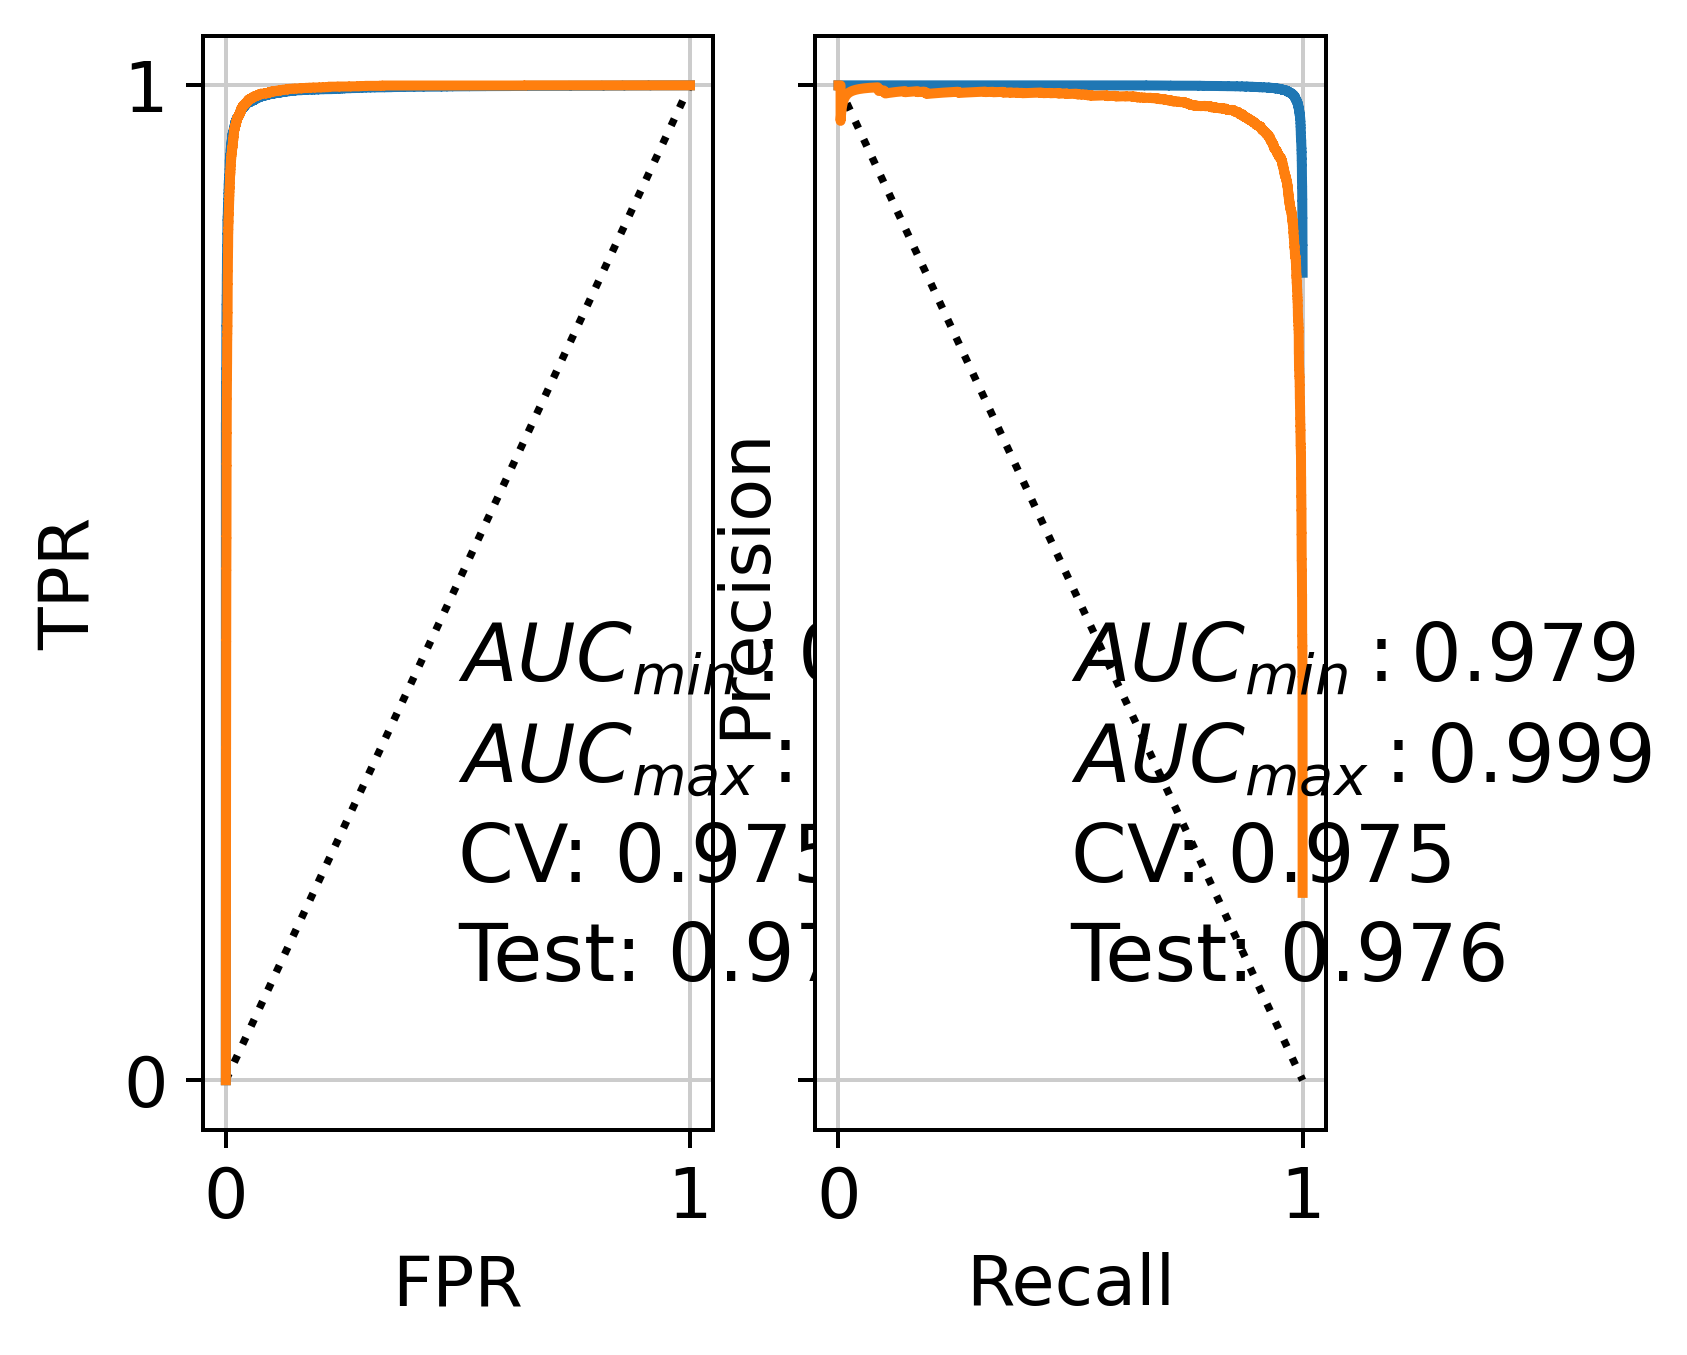

In [7]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.1, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.2 and assess with SCCAF

In [8]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/SCCAF/__init__.py:249: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_idx = df.groupby('class').apply(lambda x: msample(x, n=n, frac=frac)).index.get_level_values(None)
/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/SCCAF/__init__.py:251: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return X[c_idx, :], X[d_idx, :], y[c_idx], y[d_idx]


Mean CV accuracy: 0.8213
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8580


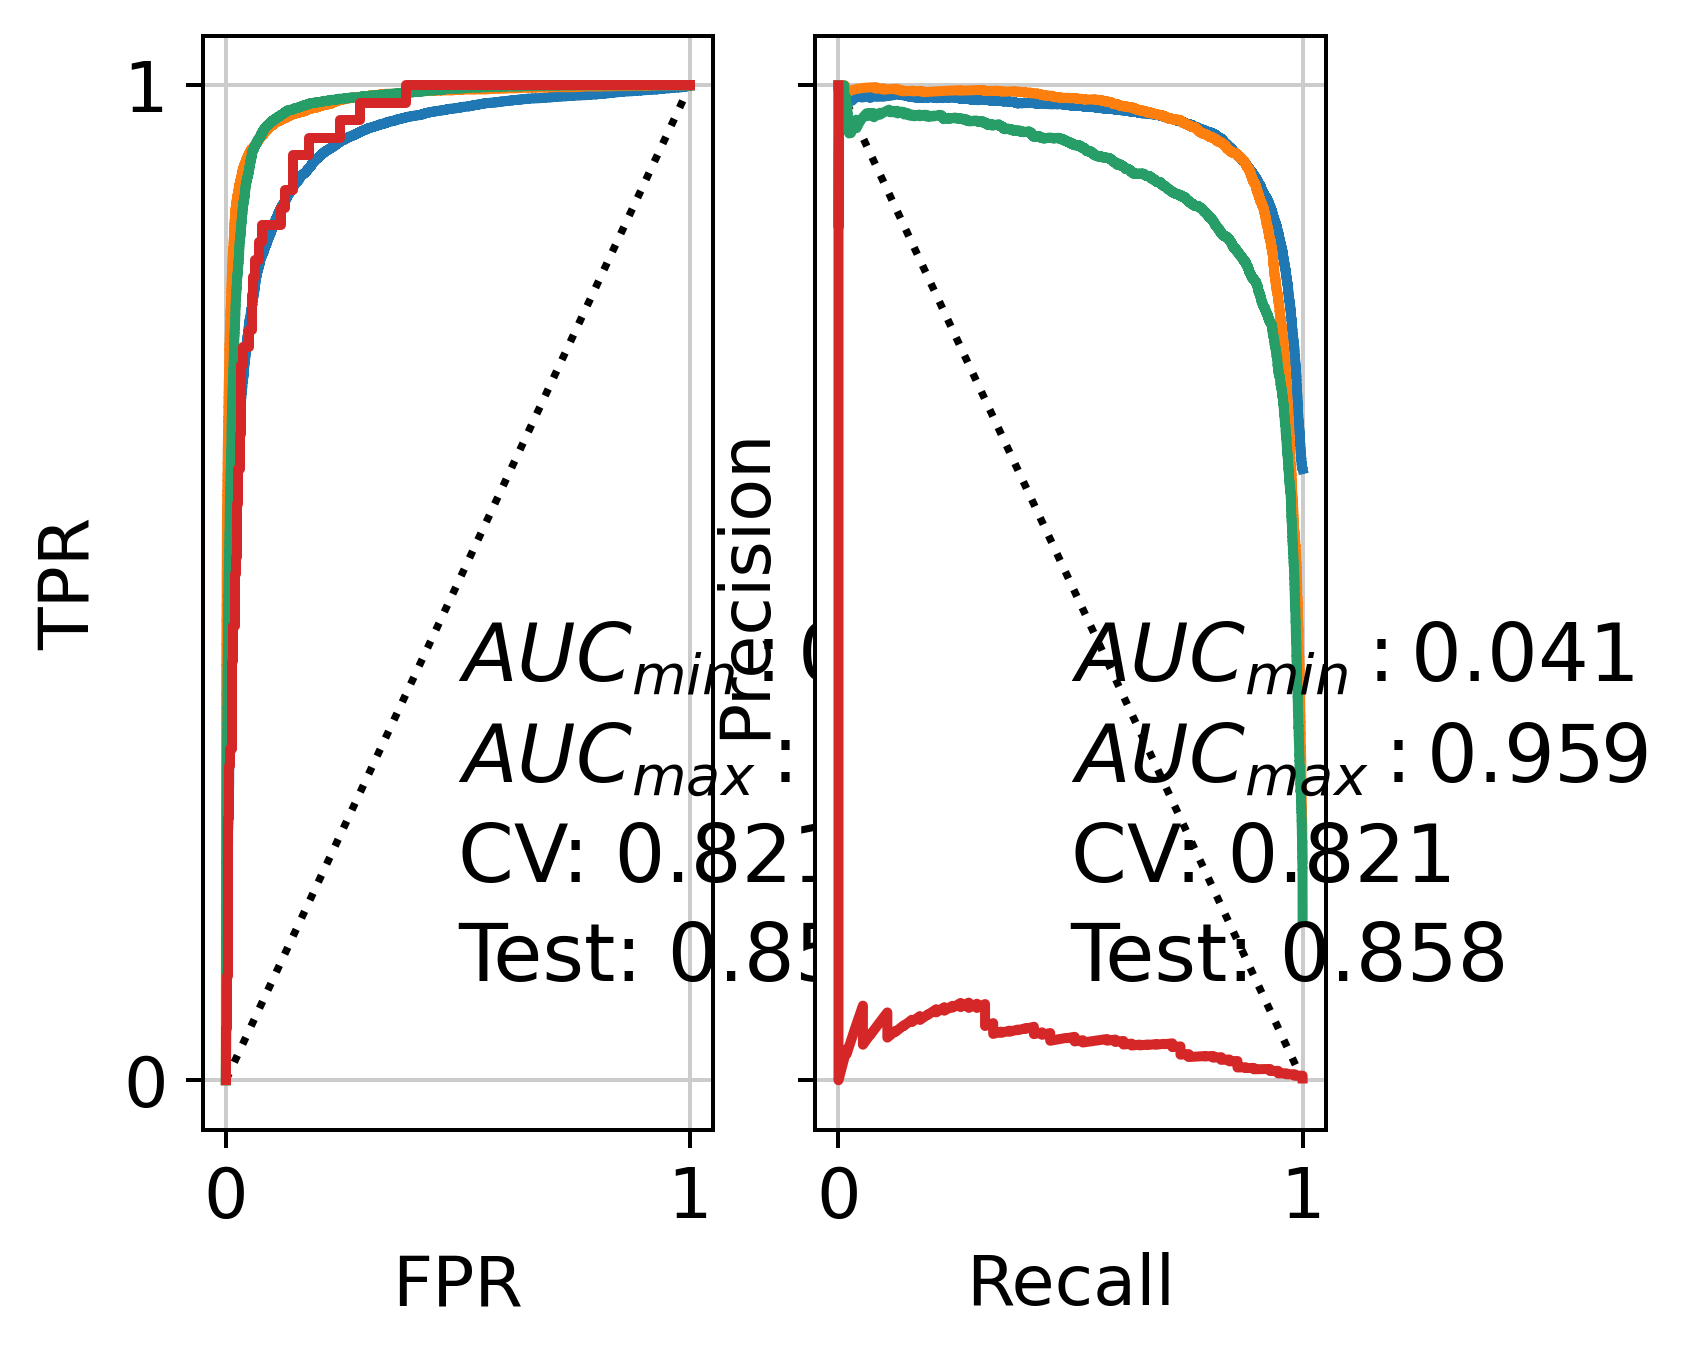

In [9]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.2, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.3 and assess with SCCAF

In [10]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/SCCAF/__init__.py:249: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_idx = df.groupby('class').apply(lambda x: msample(x, n=n, frac=frac)).index.get_level_values(None)
/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/SCCAF/__init__.py:251: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return X[c_idx, :], X[d_idx, :], y[c_idx], y[d_idx]


Mean CV accuracy: 0.8000
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.7691


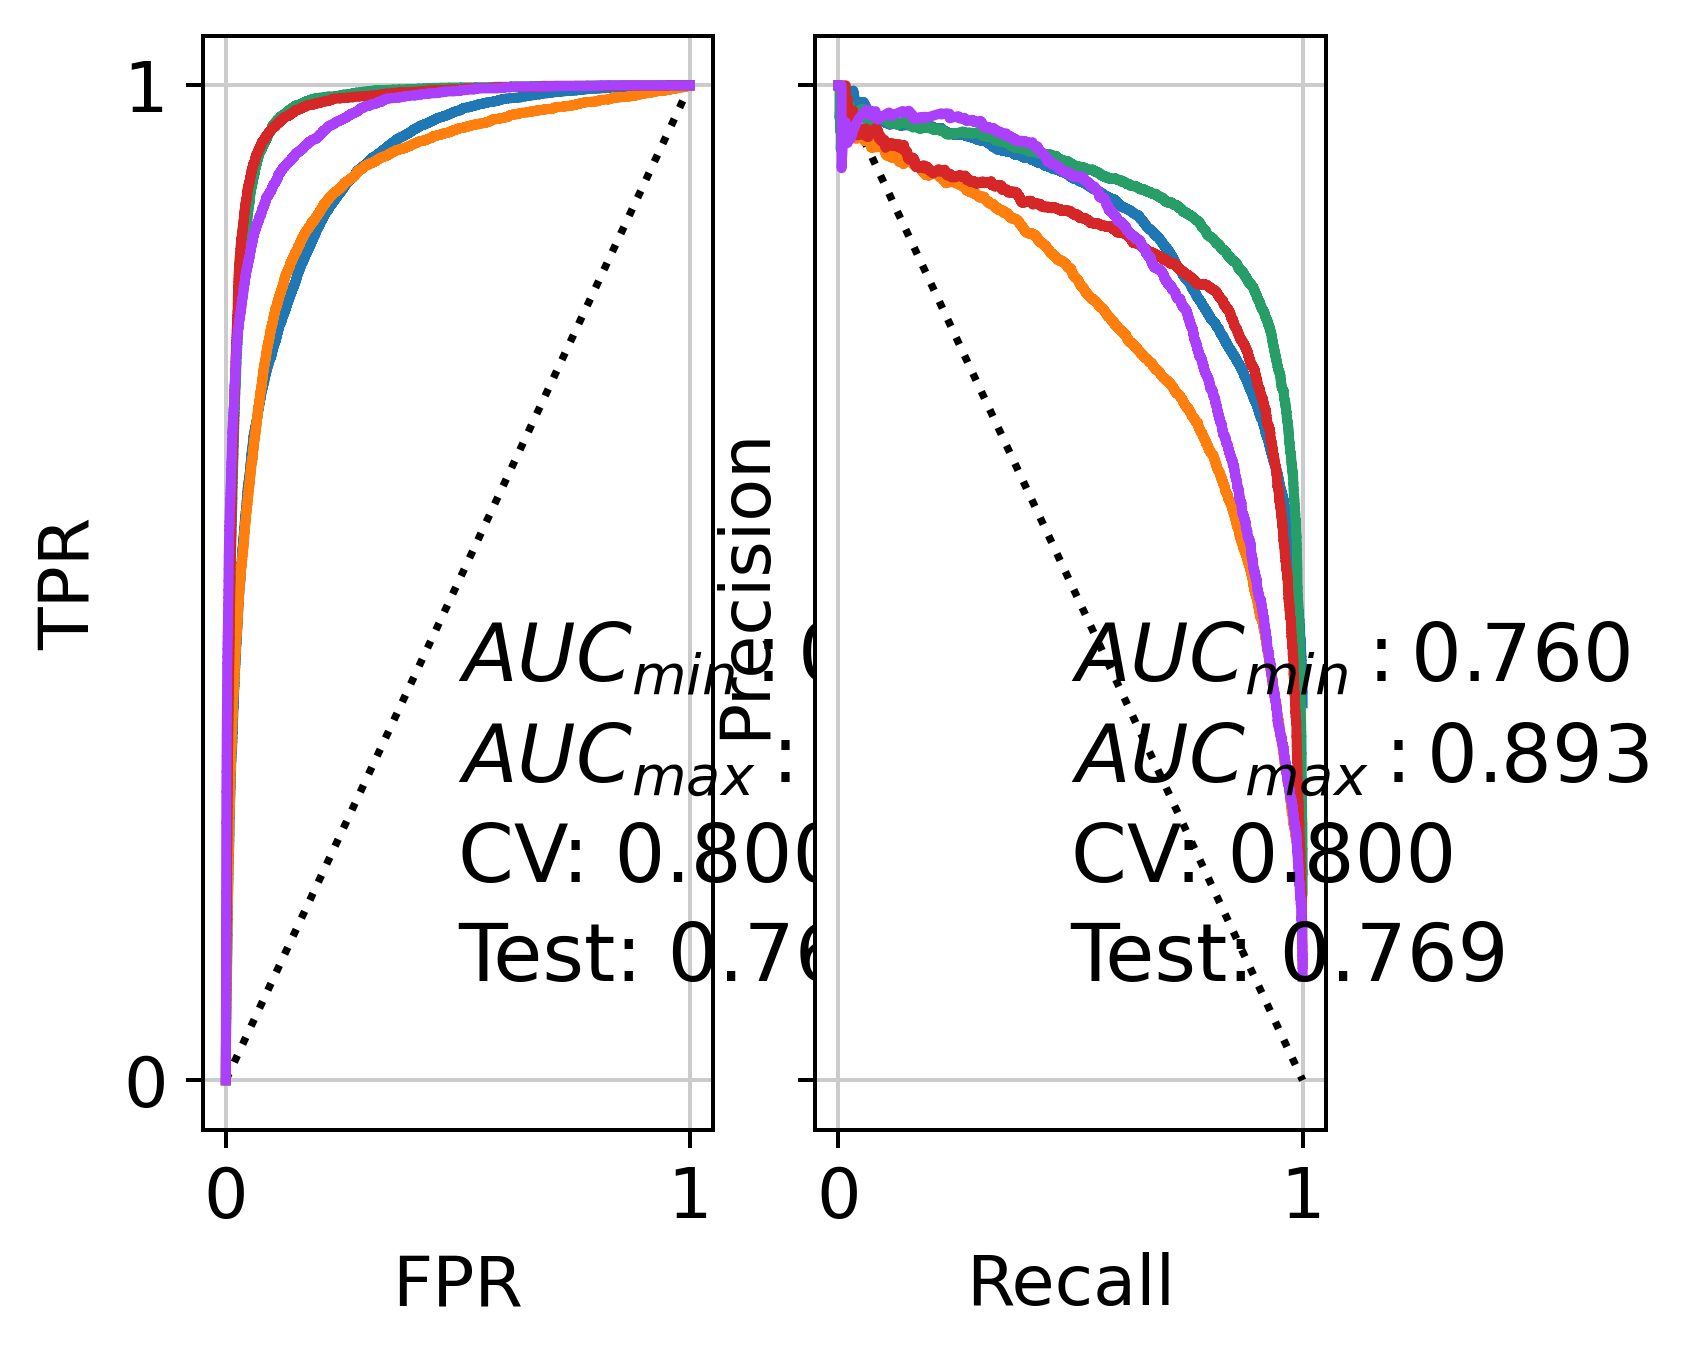

In [11]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.3, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.4 and assess with SCCAF

In [12]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/SCCAF/__init__.py:249: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_idx = df.groupby('class').apply(lambda x: msample(x, n=n, frac=frac)).index.get_level_values(None)
/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/SCCAF/__init__.py:251: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return X[c_idx, :], X[d_idx, :], y[c_idx], y[d_idx]


Mean CV accuracy: 0.7557
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.7300


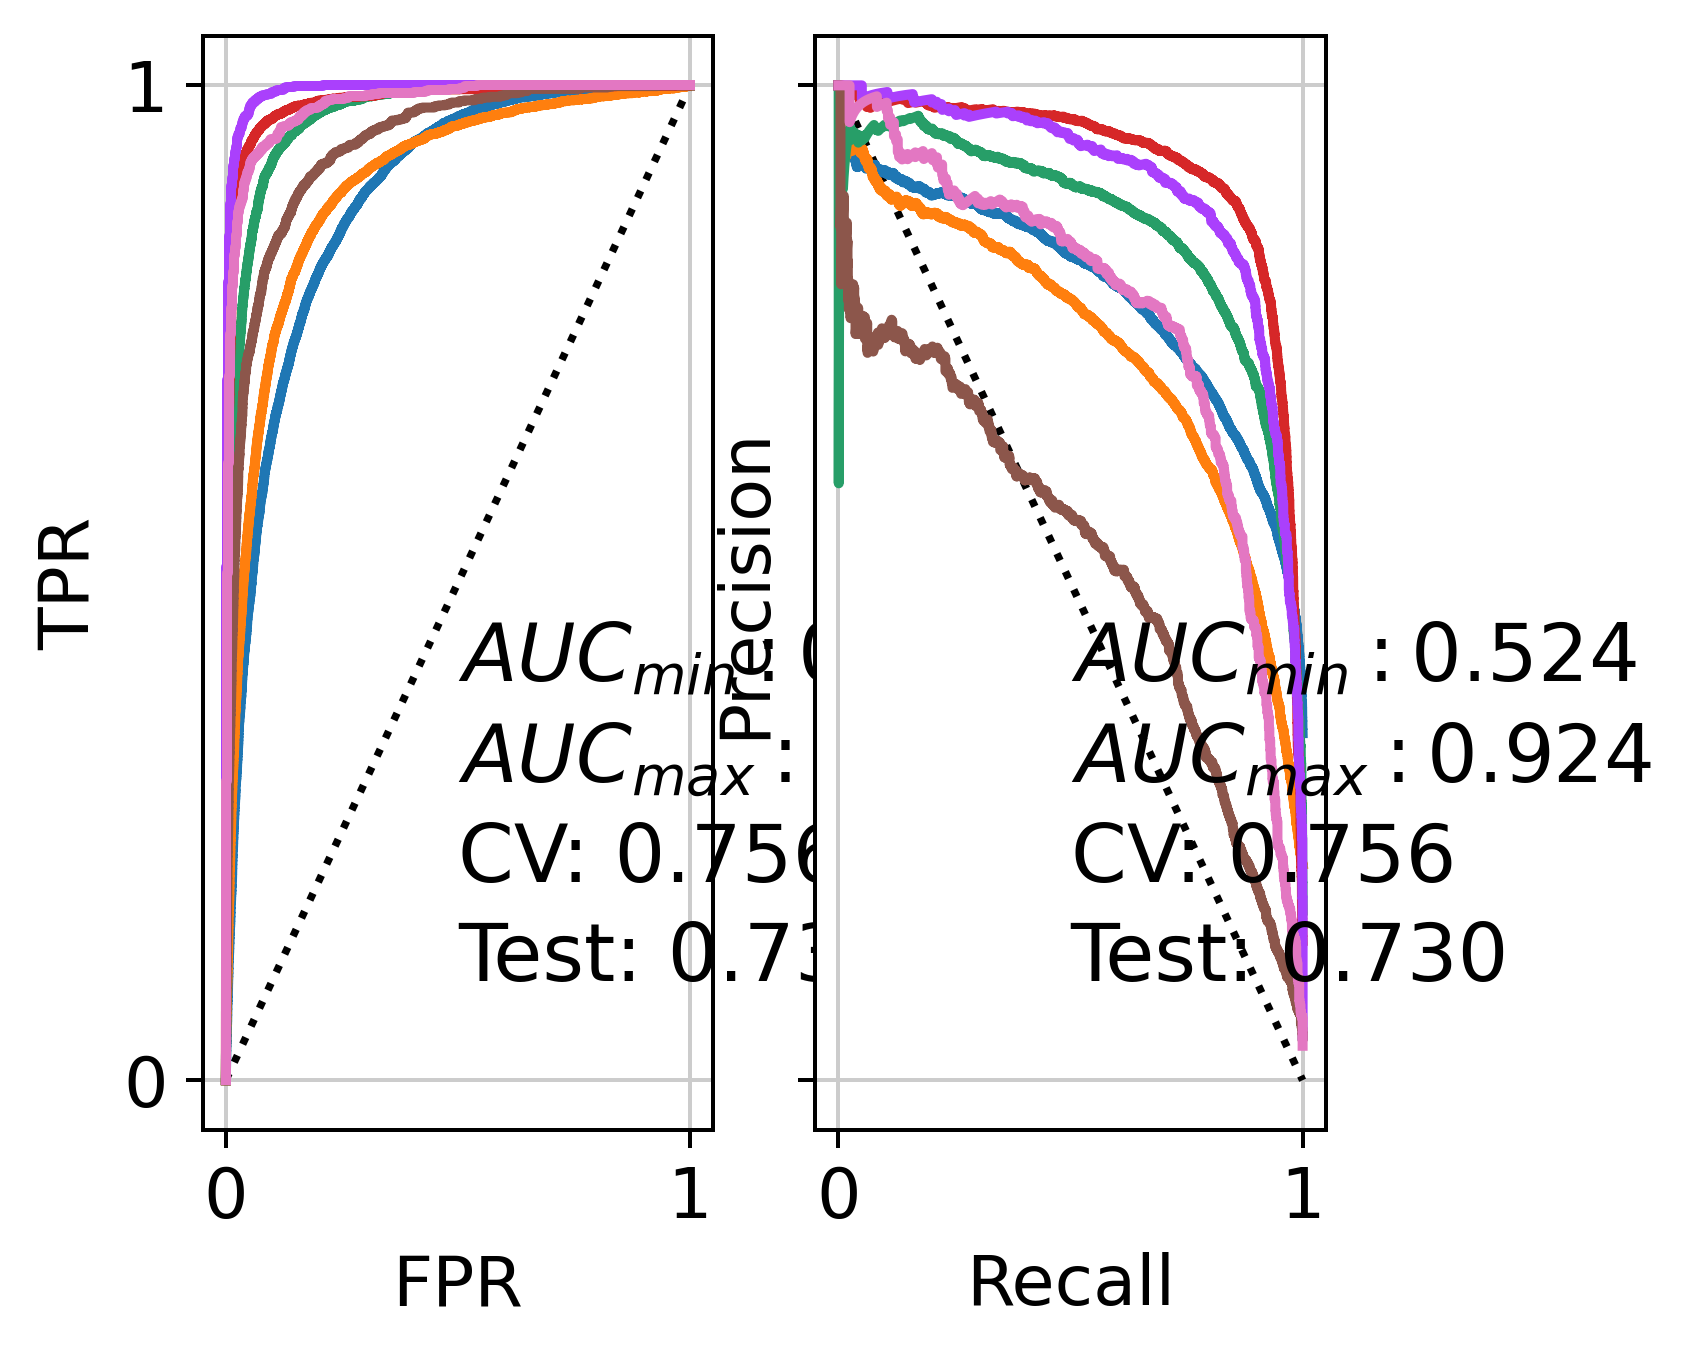

In [13]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.4, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.5 and assess with SCCAF


In [14]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/SCCAF/__init__.py:249: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_idx = df.groupby('class').apply(lambda x: msample(x, n=n, frac=frac)).index.get_level_values(None)
/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/SCCAF/__init__.py:251: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return X[c_idx, :], X[d_idx, :], y[c_idx], y[d_idx]


Mean CV accuracy: 0.6525
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.6181


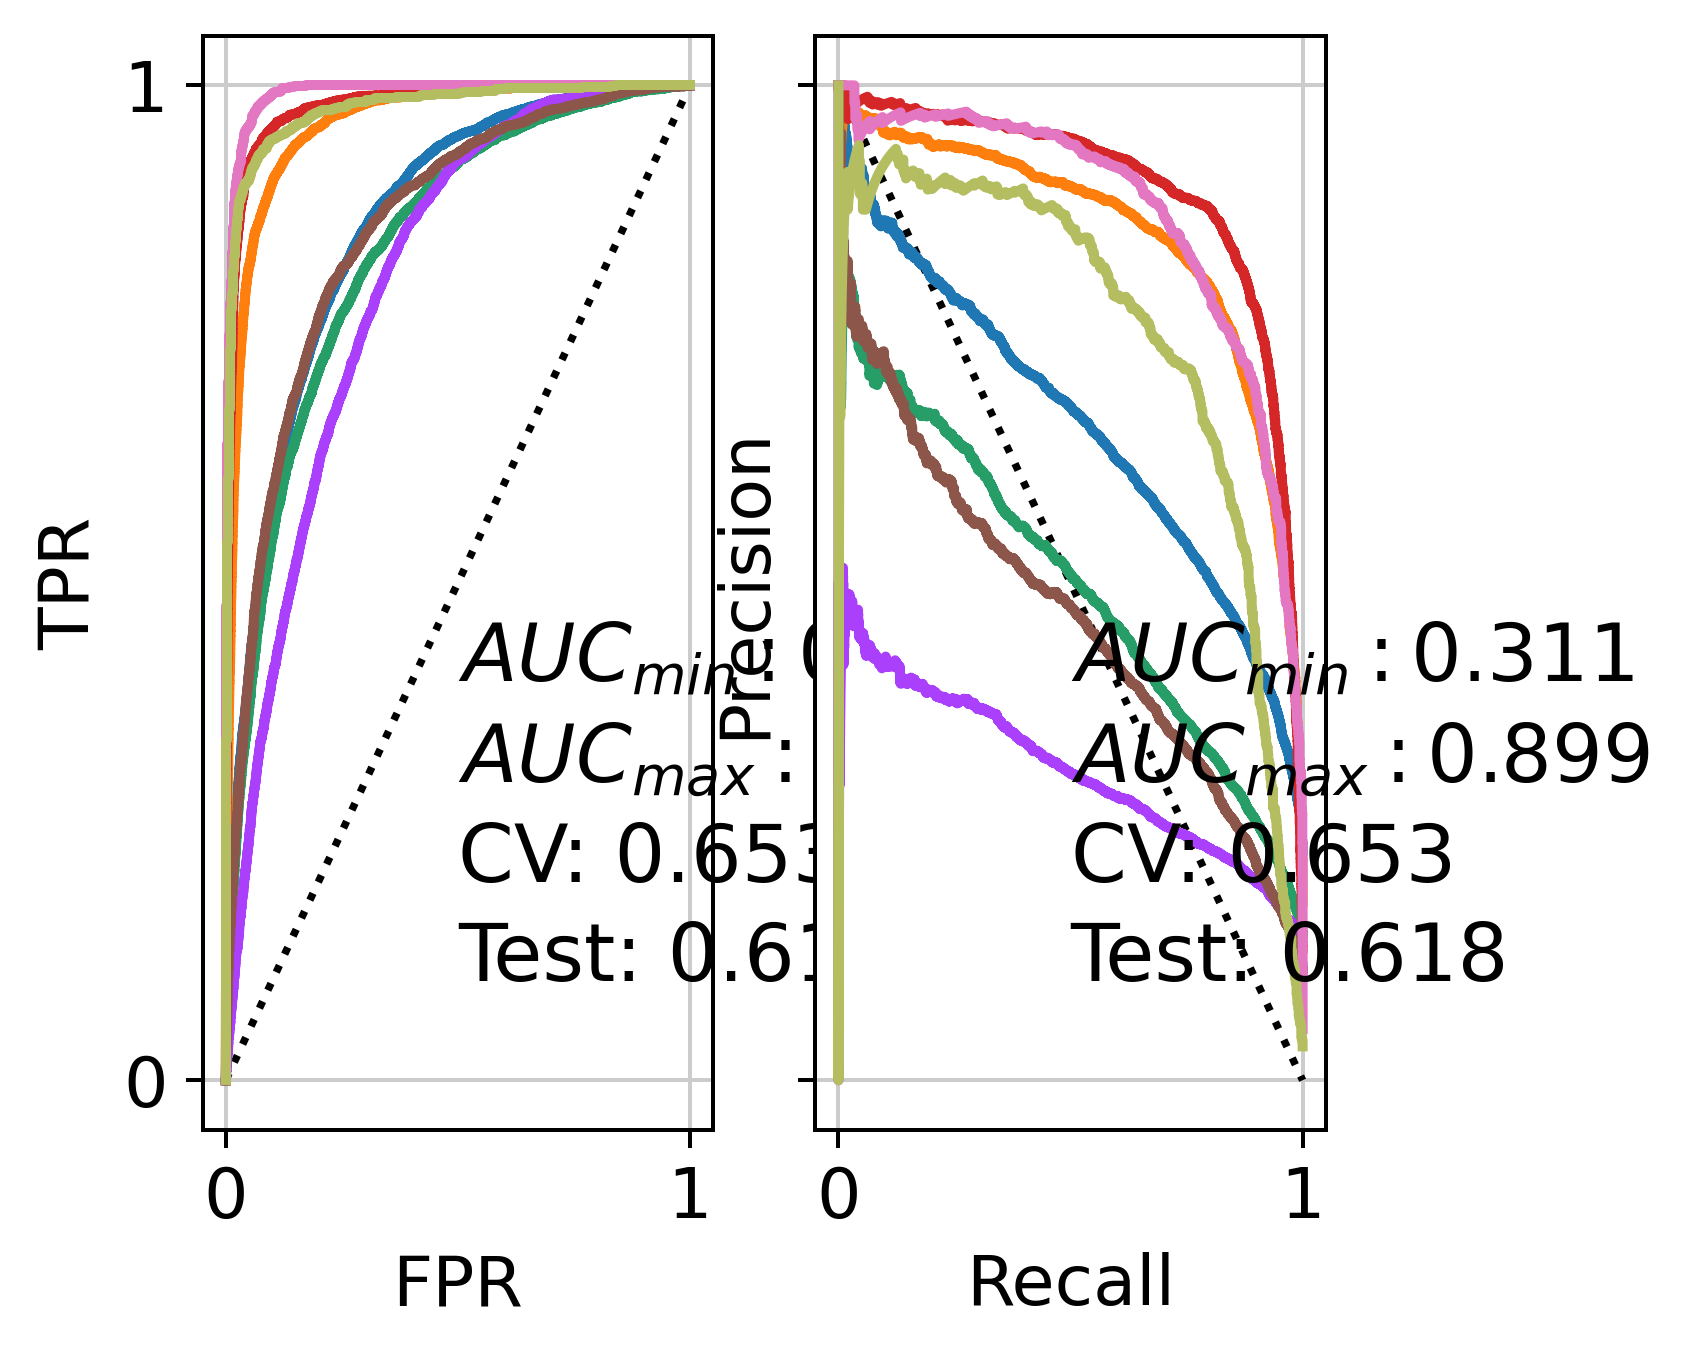

In [15]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.5, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

### Choose Resolution for `leiden` clustering
Chosen: 0.3 

In [18]:
sc.tl.leiden(adata, resolution = 0.3, random_state = 1786)

/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


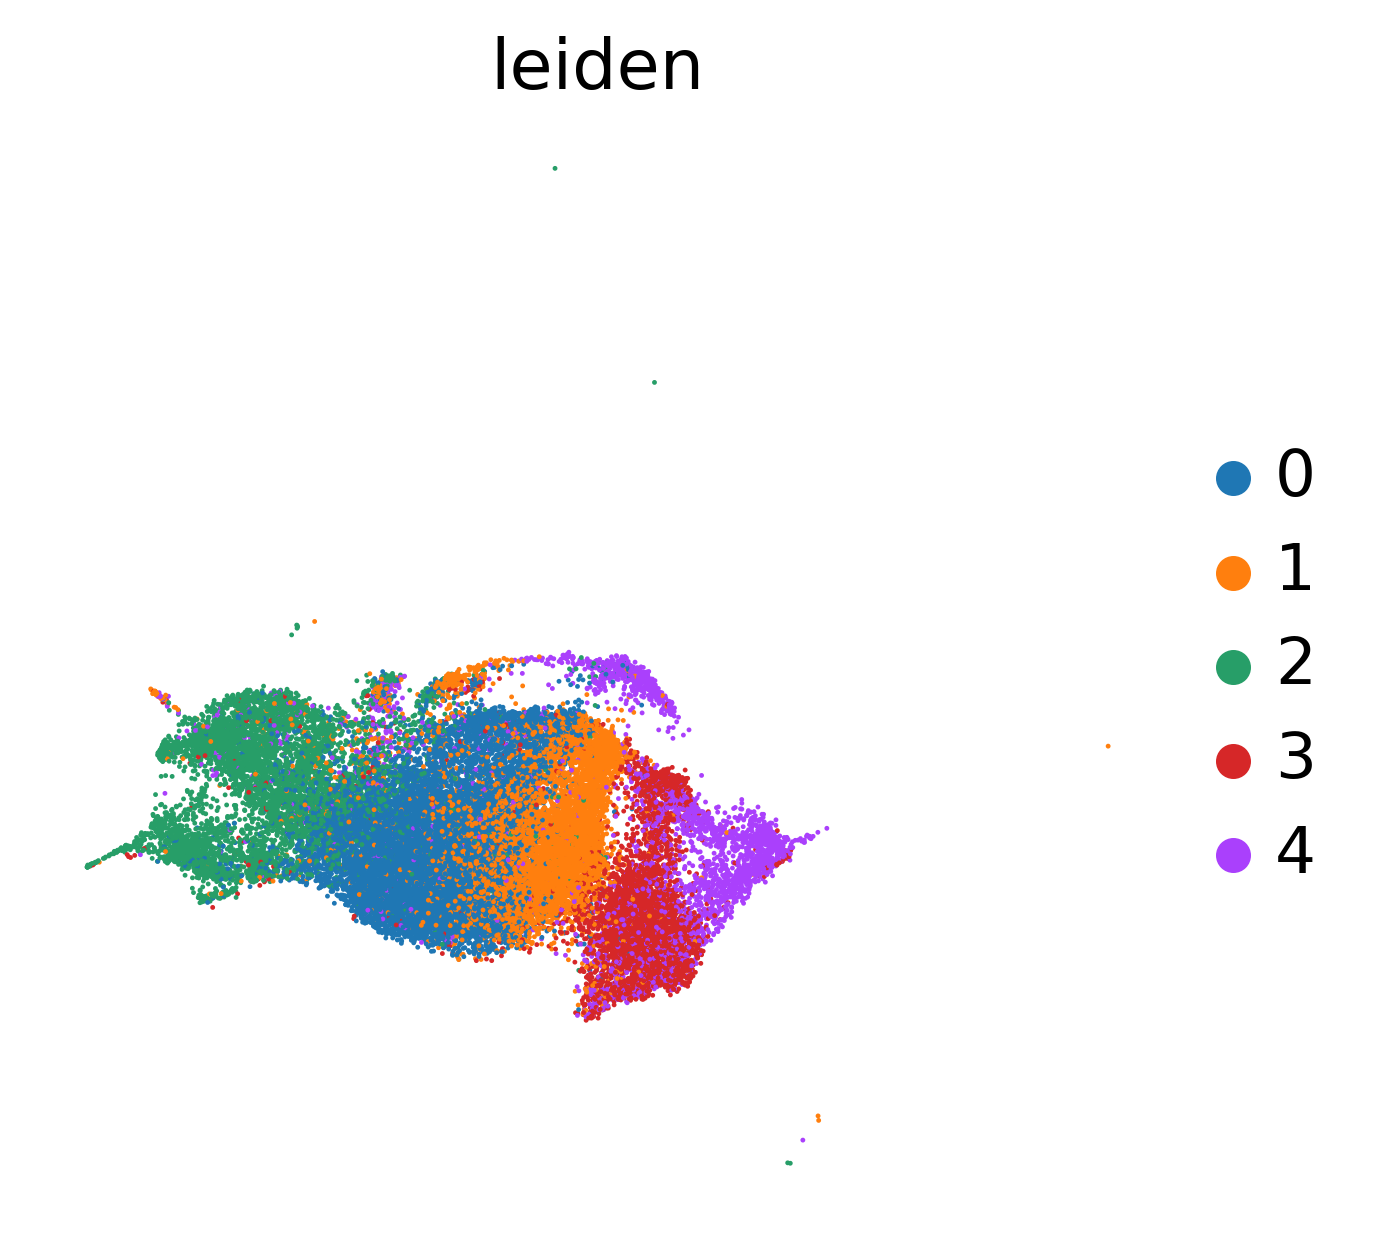

In [21]:
sc.pl.umap(adata, color=['leiden'], frameon = False)

In [22]:
#Save the results
adata.write_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Test_scVI_MoMac_sameUMAP_leiden_ac240322.raw.h5ad')

### Clustering the neighborhood graph

/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


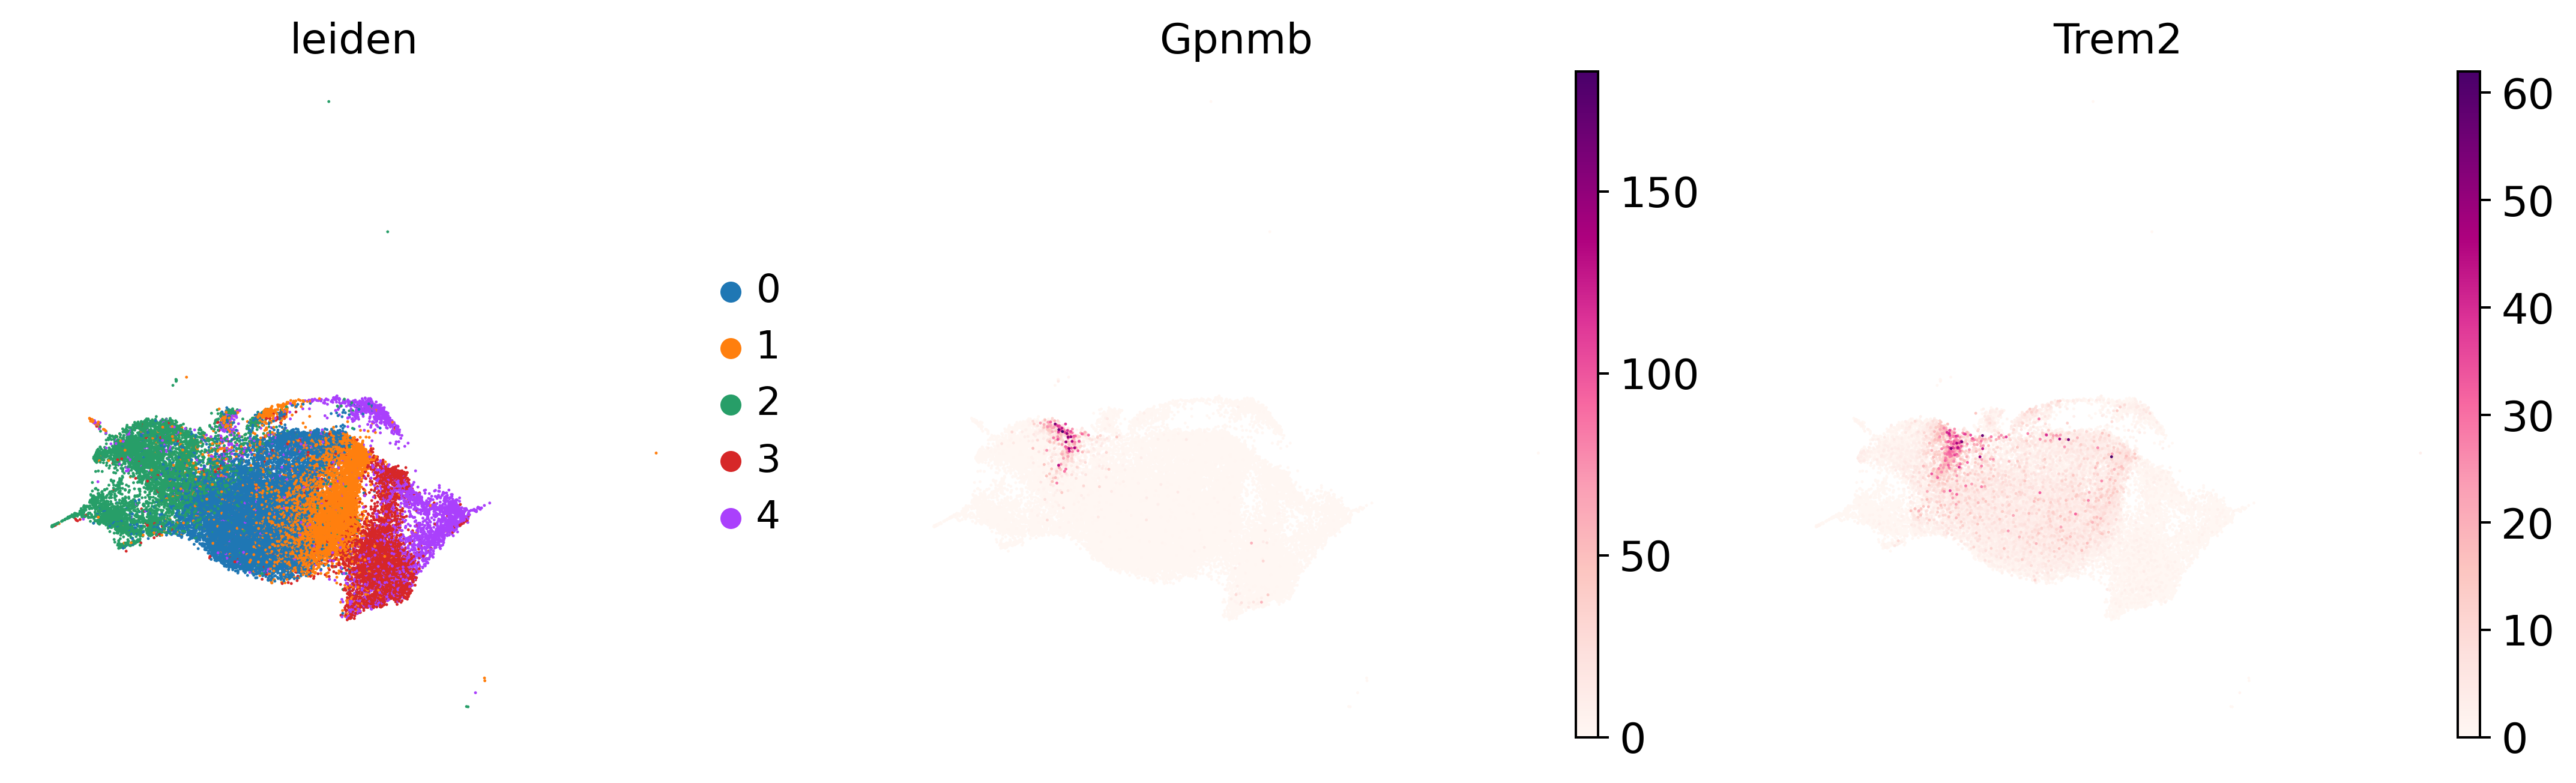

In [25]:
sc.pl.umap(adata, color=["leiden", "Gpnmb", "Trem2"], color_map='RdPu', frameon=False)

### Finding marker genes

In [26]:
sc.settings.verbosity = 2

ranking genes


/home/acirnu/miniforge3/envs/SCCAF/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished (0:00:40)


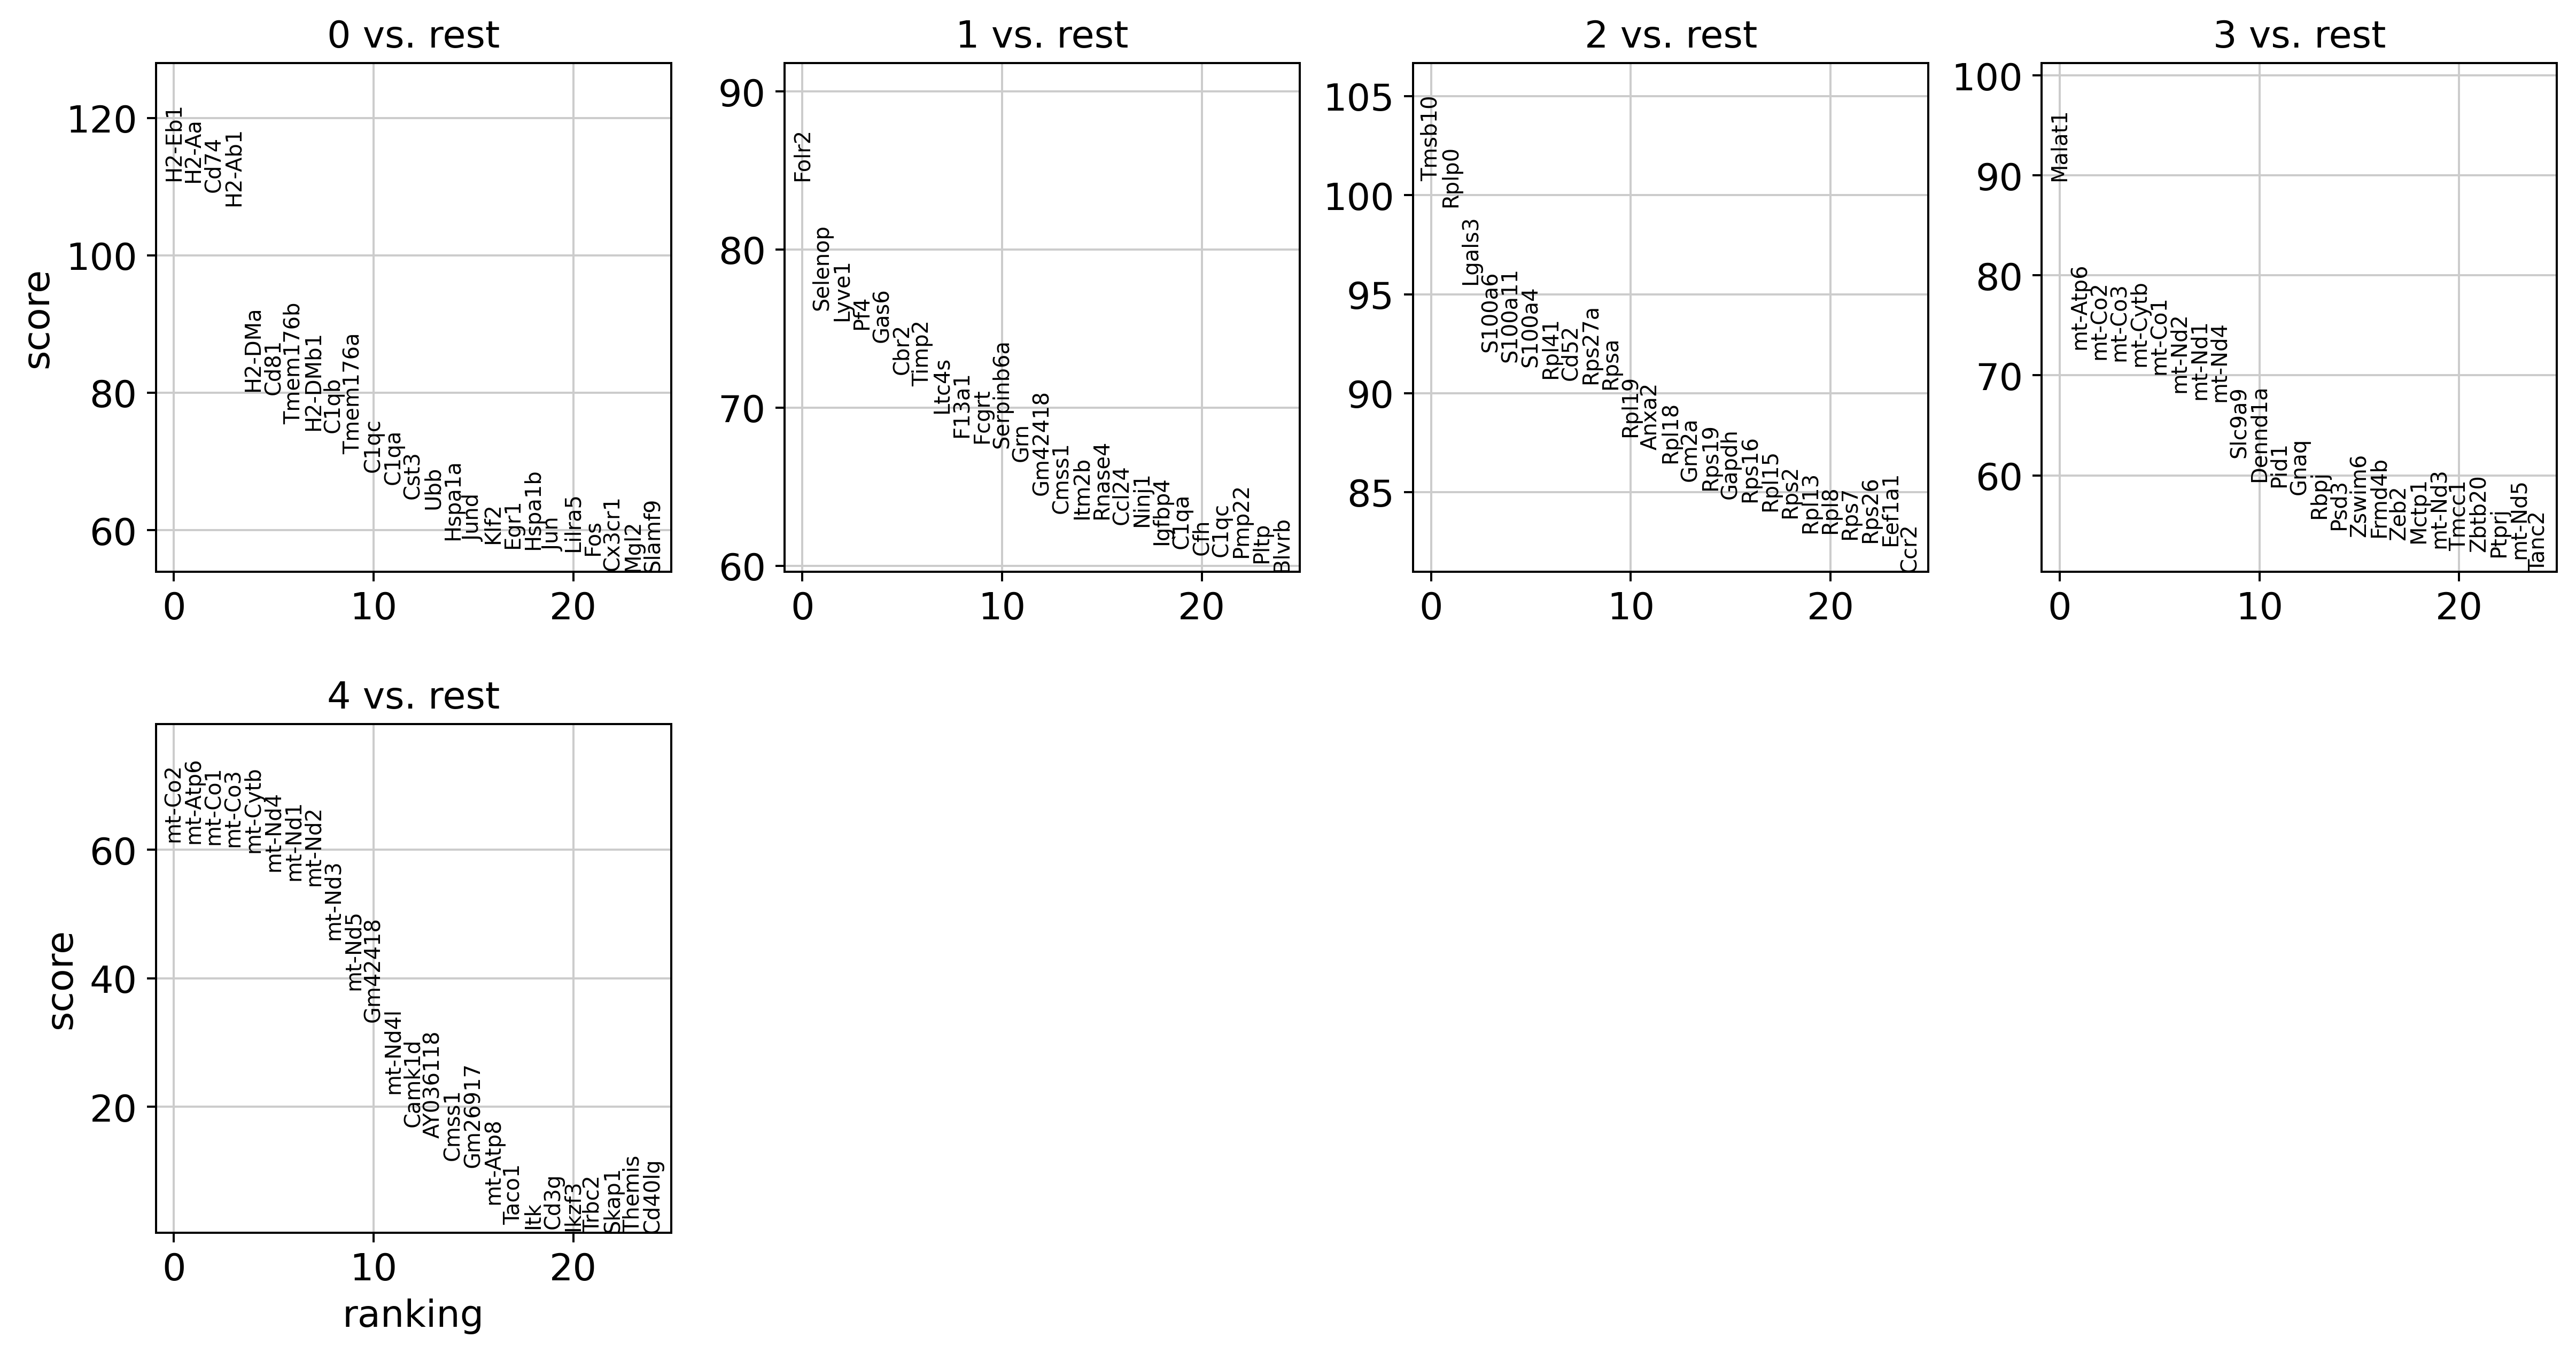

In [27]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon", use_raw=False, layer='log_norm')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the results

In [28]:
adata.write_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Test_scVI_MoMac_sameUMAP_find_markers_ac240324.raw.h5ad')

In [29]:
#Show the top 10 ranked genes per cluster
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(10)

#Cluster are in columns

,0,1,2,3,4
0,H2-Eb1,Folr2,Tmsb10,Malat1,mt-Co2
1,H2-Aa,Selenop,Rplp0,mt-Atp6,mt-Atp6
2,Cd74,Lyve1,Lgals3,mt-Co2,mt-Co1
3,H2-Ab1,Pf4,S100a6,mt-Co3,mt-Co3
4,H2-DMa,Gas6,S100a11,mt-Cytb,mt-Cytb
5,Cd81,Cbr2,S100a4,mt-Co1,mt-Nd4
6,Tmem176b,Timp2,Rpl41,mt-Nd2,mt-Nd1
7,H2-DMb1,Ltc4s,Cd52,mt-Nd1,mt-Nd2
8,C1qb,F13a1,Rps27a,mt-Nd4,mt-Nd3
9,Tmem176a,Fcgrt,Rpsa,Slc9a9,mt-Nd5


In [30]:
# Initialize an empty list to store arrays for vertical stacking
out = []
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names

# Iterate over each group
for group in groups:
    # Stack arrays vertically and append to the 'out' list
    out.append(np.vstack((
        result['names'][group],
        result['scores'][group],
        result['pvals_adj'][group],
        result['logfoldchanges'][group],
        np.array([group] * len(result['names'][group])).astype('object')
    )).T)

# Vertically stack all arrays in the 'out' list
out = np.vstack(out)

#Create a data frame
markers = pd.DataFrame(out, columns= ['Gene', 'Score', 'Adj_pvalue', 'Logfoldchange', 'Cluster'])

In [31]:
markers_filtered = markers[(markers.Adj_pvalue < 0.05) & (abs(markers.Logfoldchange) > 1)]

In [32]:
#To see the marker genes for each cluster vary the number in markers_filtered.Cluster

markers_0 = markers_filtered[markers_filtered.Cluster == '0']
markers_0.head(10)

,Gene,Score,Adj_pvalue,Logfoldchange,Cluster
0,H2-Eb1,110.883614,0.0,3.460731,0
1,H2-Aa,110.641891,0.0,3.210506,0
2,Cd74,109.244255,0.0,2.614758,0
3,H2-Ab1,107.229568,0.0,3.423284,0
4,H2-DMa,80.26329,0.0,3.388976,0
5,Cd81,79.750275,0.0,3.778259,0
6,Tmem176b,75.482948,0.0,2.995111,0
7,H2-DMb1,74.586273,0.0,3.654897,0
8,C1qb,74.213142,0.0,2.377604,0
9,Tmem176a,71.143974,0.0,3.143052,0


### Create a HeatMap

/tmp/ipykernel_831712/2796926011.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_markers = markers.groupby('Cluster', group_keys=False).apply(lambda x: x.nlargest(10, 'Logfoldchange'))


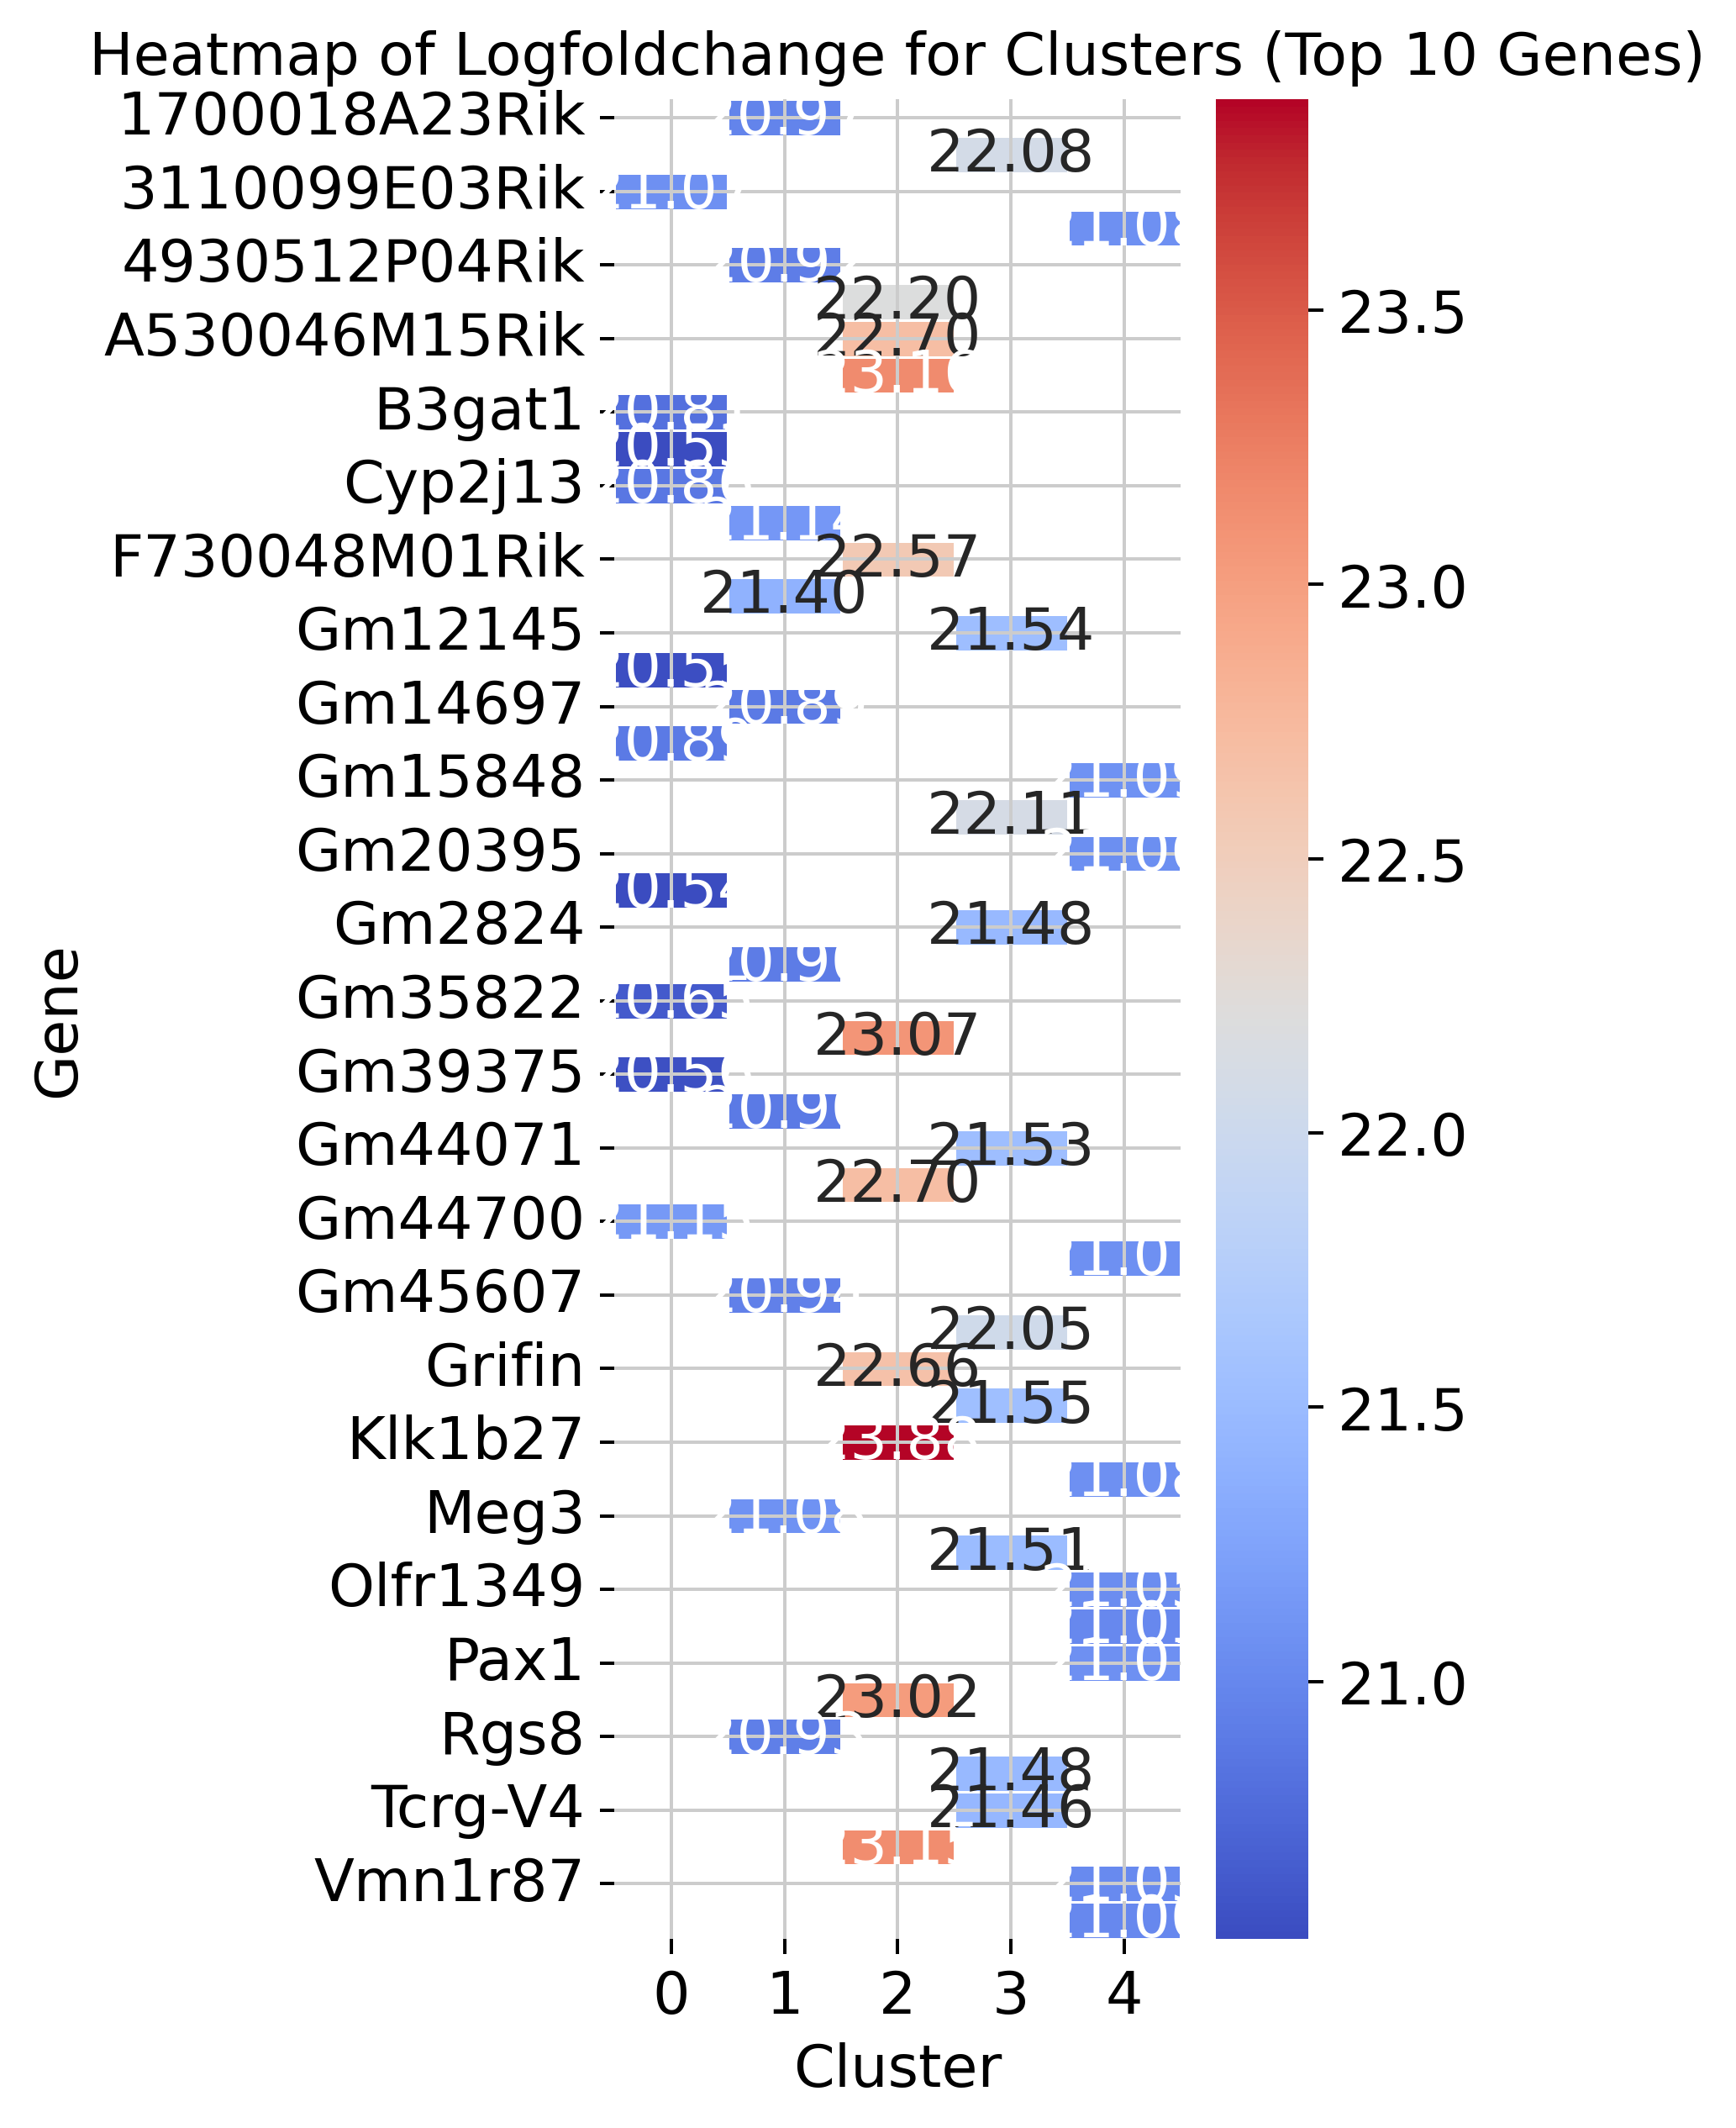

In [35]:

# Convert Logfoldchange column to numeric
markers['Logfoldchange'] = markers['Logfoldchange'].astype(float)

# Sort the dataframe by Logfoldchange within each cluster
sorted_markers = markers.groupby('Cluster', group_keys=False).apply(lambda x: x.nlargest(10, 'Logfoldchange'))

# Pivot the sorted data frame to have 'Genes' as rows, 'Cluster' as columns, and 'Logfoldchange' as values
heatmap_data = sorted_markers.pivot(index='Gene', columns='Cluster', values='Logfoldchange')

# Create heatmap
plt.figure(figsize=(3, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of Logfoldchange for Clusters (Top 10 Genes)')
plt.xlabel('Cluster')
plt.ylabel('Gene')
plt.show()


# Did not go further!!!!

In [ ]:
#Compare a gene across clusters

fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.stacked_violin(adata, var_names=['Klf2',	'Ccr2',	'Mrc1',	'mt-Atp6',	'Tmsb10',	'Napsa',	'Stmn1',	'Ftl1',	'Adgre4'], groupby="leiden", ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['Klf2',	'Ccr2',	'Mrc1',	'mt-Atp6',	'Tmsb10',	'Napsa',	'Stmn1',	'Ftl1',	'Adgre4'], groupby="leiden", ax=ax)
plt.show()

#### Visualize Dentritic cell markers

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['Itgax','Flt3', 'Itgae', 'Xcr1'], groupby="leiden", ax=ax) #Cd86 can also be expressed by DCs
plt.show()

#### Visualize markers for Tissue-resident Macros TIMD4+

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['Lyve1', 'Folr2', 'Cd163', 'Klf2', 'Cfh', 'Cbr2', 'F13a1', 'Retnla', 'Timd4'], groupby="leiden", ax=ax)
plt.show()

#### Visualize markers for Tissue-resident Macros MHCII+

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['H2-Aa','H2-Ab1','Cd83', 'Cd81', 'Cd74', 'Atf3', 'Egr1'], groupby="leiden", ax=ax)
plt.show()

#### Visualize markers for MHCII+ Il1b+

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['Cd72', 'Il1b', 'Tnip3', 'Tlr2', 'Slamf9', 'Ccrl2', 'Ccr2'], groupby="leiden", ax=ax)  
plt.show()

#### Visualize markers for Ly6Chigh Monos

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['Ly6c2', 'Plac8', 'Chil3'], groupby="leiden", ax=ax) 
plt.show()

#### Visualize markers for Ly6C-low Monos

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['Ear2', 'Ace', 'Treml4', 'Itgal'], groupby="leiden", ax=ax) 
plt.show()

#### Visualize markers for Trem2hi Spp1hi

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['Lgals3', 'Ctsd', 'Ctsl', 'Fabp5', 'Gpnmb', 'Arg1', 'Anxa1', 'Spp1'], groupby="leiden", ax=ax) 
plt.show()

#### Visualize markers for Trem2hi Gdf15hi

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['Selenop', 'Psap', 'Gdf15', 'Apoe', 'Fcrls', 'Fabp4'], groupby="leiden", ax=ax) 
plt.show()

#### Visualize markers for Trem2hi Prdx1hi

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['Prdx1', 'Slc40a1', 'Ftl1', 'Fth1'], groupby="leiden", ax=ax) 
plt.show()

#### Visualize markers for Isg15hi

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['Isg15', 'Rsad2', 'C4b', 'Ecm1'], groupby="leiden", ax=ax) 
plt.show()

#### Visualize markers for Fn1hi Ltc4shi

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sc.pl.dotplot(adata, var_names=['Mcm2', 'Stmn1', 'Ccnd1'], groupby="leiden", ax=ax) 
plt.show()

### Visualize all marker genes in one plot

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sc.pl.dotplot(adata, var_names=['Lyve1', 'Folr2', 'Cd163', 'Klf2', 'Cfh', 'Cbr2', 'F13a1', 'Retnla', 'Timd4','H2-Aa','H2-Ab1','Cd83', 'Cd81', 'Cd74', 'Atf3', 'Egr1', 'Cd72', 'Il1b', 'Tnip3', 'Tlr2', 'Slamf9', 'Ccrl2', 'Ccr2', 'Ly6c2', 'Plac8', 'Chil3', 'Ear2', 'Ace', 'Treml4', 'Itgal', 'Lgals3', 'Ctsd', 'Ctsl', 'Fabp5', 'Gpnmb', 'Arg1', 'Anxa1', 'Spp1', 'Selenop', 'Psap', 'Gdf15', 'Apoe', 'Fcrls', 'Fabp4', 'Prdx1', 'Slc40a1', 'Ftl1', 'Fth1', 'Isg15', 'Rsad2', 'C4b', 'Ecm1', 'Mcm2', 'Stmn1', 'Ccnd1'], groupby="leiden", ax=ax)
plt.show()

### Annotate the clusters - DID NOT DO THAT YET

In [ ]:
new_cluster_names = [
    "Monocytes/Macrophages",
    "CD8 T/NK",
    "Neutrophils",
    "CD4 T",
    "DC",
    "T cell subset",
    "B cell",
    "Mast",
    "Eosinophils"
]
adata.rename_categories("leiden", new_cluster_names)

Change the order of the clusters

In [ ]:
desired_cluster_order = ["Monocytes/Macrophages", "DC", "Mast", "Neutrophils", "Eosinophils",  "CD4 T", "CD8 T/NK", "T cell subset", "B cell"]
adata.obs['leiden'] = pd.Categorical(adata.obs['leiden'], categories=desired_cluster_order, ordered=True)

In [ ]:
sc.pl.umap(adata, color="leiden", legend_loc="right margin", title="", frameon=False)

In [ ]:
adata.obs

### Visualize on UMAP

In [ ]:
def split_umap(adata, split_by, ncol=2, nrow=None, **kwargs):
    categories = adata.obs[split_by].cat.categories
    if nrow is None:
        nrow = int(np.ceil(len(categories) / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))
    axs = axs.flatten()
    for i, cat in enumerate(categories):
        ax = axs[i]
        sc.pl.umap(adata[adata.obs[split_by] == cat], ax=ax, show=False, title=cat, **kwargs)
    plt.tight_layout()

In [ ]:
split_umap(adata, color = ['leiden'], split_by = 'infection', frameon = False, size = 5, legend_fontsize = 10, ncols = 4, palette = {
               "Monocytes/Macrophages":      '#FFD900',  # Yellow
               "DC":                         '#C70039',  # Crimson (Closest to primary palette) 
               "Mast":                       '#FF7F0E',  # Orange (Closest to primary palette)
               "Neutrophils":                '#BCBD22',  # Muted Yellow (original color kept)
               "Eosinophils":                '#98DF8A',  # Muted Green (original color kept)
               "CD4 T":                      '#ADD8E6',  # Light Blue
               "CD8 T/NK":                   '#4169E1',  # Medium Blue 
               "T cell subset":              '#984EA3',  # Purple 
               "B cell":                     '#E377C2'   # Pinkish (original color kept)
           })

In [ ]:
split_umap(adata, color = ['leiden'], split_by = 'condition', frameon = False, size = 10, legend_fontsize = 10, ncols = 4, palette = {
               "Monocytes/Macrophages":      '#FFD900',  # Yellow
               "DC":                         '#C70039',  # Crimson (Closest to primary palette) 
               "Mast":                       '#FF7F0E',  # Orange (Closest to primary palette)
               "Neutrophils":                '#BCBD22',  # Muted Yellow (original color kept)
               "Eosinophils":                '#98DF8A',  # Muted Green (original color kept)
               "CD4 T":                      '#ADD8E6',  # Light Blue
               "CD8 T/NK":                   '#4169E1',  # Medium Blue 
               "T cell subset":              '#984EA3',  # Purple 
               "B cell":                     '#E377C2'   # Pinkish (original color kept)
           })

In [ ]:
split_umap(adata, color = ['leiden'], split_by = 'genotype', frameon = False, size = 10, legend_fontsize = 10, ncols = 4, palette = {
               "Monocytes/Macrophages":      '#FFD900',  # Yellow
               "DC":                         '#C70039',  # Crimson (Closest to primary palette) 
               "Mast":                       '#FF7F0E',  # Orange (Closest to primary palette)
               "Neutrophils":                '#BCBD22',  # Muted Yellow (original color kept)
               "Eosinophils":                '#98DF8A',  # Muted Green (original color kept)
               "CD4 T":                      '#ADD8E6',  # Light Blue
               "CD8 T/NK":                   '#4169E1',  # Medium Blue 
               "T cell subset":              '#984EA3',  # Purple 
               "B cell":                     '#E377C2'   # Pinkish (original color kept)
           })

In [ ]:
split_umap(adata, color = ['leiden'], split_by = 'model', frameon = False, size = 5, legend_fontsize = 10, ncols = 4, palette = {
               "Monocytes/Macrophages":      '#FFD900',  # Yellow
               "DC":                         '#C70039',  # Crimson (Closest to primary palette) 
               "Mast":                       '#FF7F0E',  # Orange (Closest to primary palette)
               "Neutrophils":                '#BCBD22',  # Muted Yellow (original color kept)
               "Eosinophils":                '#98DF8A',  # Muted Green (original color kept)
               "CD4 T":                      '#ADD8E6',  # Light Blue
               "CD8 T/NK":                   '#4169E1',  # Medium Blue 
               "T cell subset":              '#984EA3',  # Purple 
               "B cell":                     '#E377C2'   # Pinkish (original color kept)
           })

### Visualize cell type proportions as stacked barplots

In [ ]:
df = adata.obs.groupby(['condition', 'leiden']).size().reset_index(name = 'counts')

grouped = df.groupby('condition')['counts'].apply(lambda x: x / x.sum() * 100)
grouped = grouped.reset_index()

df['proportions'] = grouped['counts']
df.head(10)

In [ ]:
Pkp2_conditions = ["Pkp2_Ctr_noninf", "Pkp2_HetKO_noninf","Pkp2_Ctr_MCMV", "Pkp2_HetKO_MCMV"]
df_Pkp2 = df[df['condition'].isin(Pkp2_conditions)]
df_Pkp2 = df_Pkp2.set_index('condition').loc[Pkp2_conditions].reset_index()

In [ ]:
#Define a color map
cmap_ac = ['#FFD900','#C70039','#FF7F0E','#BCBD22','#98DF8A','#ADD8E6', '#4169E1','#984EA3','#E377C2']  

# Pivot the DataFrame to have 'leiden' clusters as columns
pivot_df = df_Pkp2.pivot(index='condition', columns='leiden', values='proportions').fillna(0)

# Plot the stacked barplot
plt.figure()  # Create a new figure
pivot_df.plot(kind='bar', stacked=True, color = cmap_ac, edgecolor='none', )

# Set the figure size explicitly after creating the figure
plt.gcf().set_size_inches(8, 6)

# Add labels and title
plt.xlabel('')
plt.ylabel('Proportion (%)')
plt.title('')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
Ttn_conditions = ["Ttn_Ctr_noninf", "Ttn_HetKO_noninf","Ttn_Ctr_MCMV", "Ttn_HetKO_MCMV"]
df_Ttn = df[df['condition'].isin(Ttn_conditions)]
df_Ttn = df_Ttn.set_index('condition').loc[Ttn_conditions].reset_index()

In [ ]:
#Define a color map
cmap_ac = ['#FFD900','#C70039','#FF7F0E','#BCBD22','#98DF8A','#ADD8E6', '#4169E1','#984EA3','#E377C2']  

# Pivot the DataFrame to have 'leiden' clusters as columns
pivot_df = df_Ttn.pivot(index='condition', columns='leiden', values='proportions').fillna(0)

# Plot the stacked barplot
plt.figure()  # Create a new figure
pivot_df.plot(kind='bar', stacked=True, color = cmap_ac, edgecolor='none', )

# Set the figure size explicitly after creating the figure
plt.gcf().set_size_inches(8, 6)

# Add labels and title
plt.xlabel('')
plt.ylabel('Proportion (%)')
plt.title('')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

#### Save the clustered data set

In [ ]:
adata

In [ ]:
adata.write_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Test_scVI_annotated_ac240324.raw.h5ad')  